### Weather Recognition

In [2]:
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications import VGG16 
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.math import confusion_matrix

###### Global Variables

In [1]:
dataset_path = './dataset/'
train_path = './images/train/'
validation_path = './images/validation/'
test_path = './images/test/'
augmented_path = './images/augmented/'
WIDTH = 76
HEIGHT = 76
NO_CLASSES = 11

#### Separate dataset for training and testing

###### Create folders to save images

In [ ]:
if 'images' not in os.listdir(os.curdir):
    os.mkdir('./images')

if train_path not in os.listdir('./images/'):
    os.mkdir(train_path)

if test_path not in os.listdir('./images/'):
    os.mkdir(test_path)

if validation_path not in os.listdir('./images/'):
    os.mkdir(validation_path)

if augmented_path not in os.listdir('./images/'):
    os.mkdir(augmented_path)

###### Divide dataset for trainning and testing

In [ ]:
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    folder_train_path = os.path.join(train_path, folder)
    folder_validation_path = os.path.join(validation_path, folder)
    folder_test_path = os.path.join(test_path, folder)
    
    folder_images_count = len(os.listdir(folder_path))

    # Create train, validation and test folders
    if folder not in os.listdir(train_path):
        os.mkdir(folder_train_path)
    if folder not in os.listdir(validation_path):
        os.mkdir(folder_validation_path)
    if folder not in os.listdir(test_path):
        os.mkdir(folder_test_path)

    # Create thresholds for dividing images in folders
    image_counter = 0
    train_threshold = folder_images_count * 0.7
    validation_threshold = train_threshold + (folder_images_count * 0.1) 
    test_threshold = validation_threshold + (folder_images_count * 0.2)

    # Resize and save images into folders
    image_path = ''
    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image)
        resized_image = cv2.imread(image_path)

        if isinstance(resized_image, type(None)):
            continue

        resized_image = cv2.resize(resized_image, (WIDTH, HEIGHT))

        if image_counter <= train_threshold:
            cv2.imwrite(os.path.join(folder_train_path, image), resized_image)
        elif image_counter >= train_threshold and image_counter < validation_threshold: 
            cv2.imwrite(os.path.join(folder_validation_path, image), resized_image)
        elif image_counter >= validation_threshold and image_counter < test_threshold:
            cv2.imwrite(os.path.join(folder_test_path, image), resized_image)

        image_counter += 1

#### Create and Train Models

##### Misc Functions

###### Get class of an image in the dictionary of classes. This function returns the name of the class (key) based on its index value. 

In [6]:
def get_img_class(class_indices, index):
    for _index in class_indices:
        if class_indices[_index] == index:
            return _index
    
    return ''

###### Generic function to show the training of a model

In [7]:
def train_model(history):
    acc = history.history['acc']
    loss = history.history['loss']
    # podria graficar el validation...

    epochs = range(1, len(acc)+1)

    plt.plot(epochs, acc, 'bo', label='Train accuracy')
    plt.title('Train acc')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.title('Train loss')
    plt.legend()

    plt.show()

###### Generic function to test a model

In [8]:
test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (WIDTH, HEIGHT),
    batch_size = 1367,
    class_mode= 'categorical'
)

def test_model(model):
    test_loss, test_acc = model.evaluate_generator(test_generator, steps = 1)
    print('\nTest Accuracy:\n', test_acc)

    return test_acc

Found 1367 images belonging to 11 classes.


###### Generate confusion matrix of a model

In [9]:
def generate_confusion_matrix(model):
    test_images = test_generator[0][0]
    test_labels = test_generator[0][1]

    predictions = model.predict(test_images)
    classes_x = np.argmax(predictions,axis=1)
    test_labels = np.argmax(test_labels, axis = 1)

    return confusion_matrix(classes_x, test_labels)

##### Simple CNN

###### Train generator

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (WIDTH, HEIGHT),
    batch_size = 8,
    class_mode ='categorical',
)

Found 4809 images belonging to 11 classes.


###### Display images for training

11 classes
{'dew': 0, 'fogsmog': 1, 'frost': 2, 'glaze': 3, 'hail': 4, 'lightning': 5, 'rain': 6, 'rainbow': 7, 'rime': 8, 'sandstorm': 9, 'snow': 10}


<Figure size 432x288 with 0 Axes>

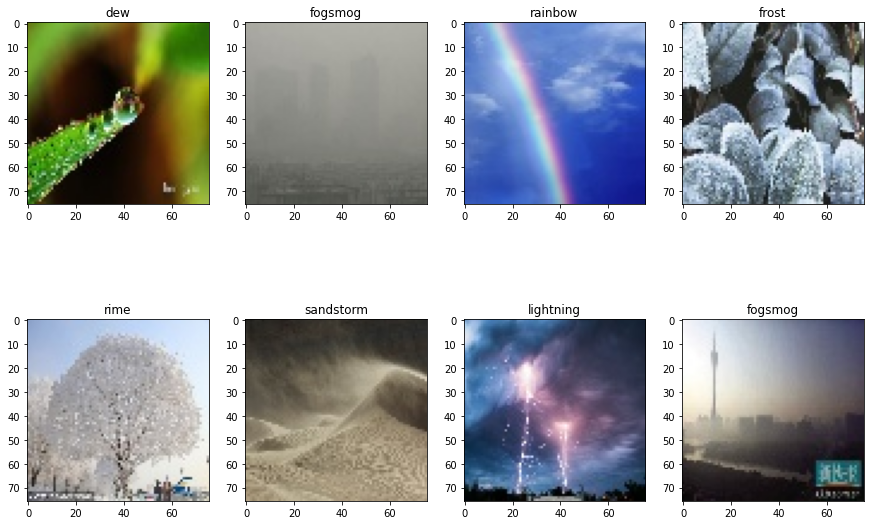

In [11]:
# Got the same amount of classes of the images. Each class has an ID mapped to the name of the class (dew:0, fogsmog:1, ..., snow:11)
class_indices = train_generator.class_indices
print(str(len(class_indices)) + ' classes')
print(class_indices)

images, labels = train_generator[0]

plt.figure()
f, axarr = plt.subplots(2, int(images.shape[0] / 2), figsize=(15, 10)) 

img_index = 0 
for row in range(0, 2):
	for col in range(0, int(images.shape[0] / 2)):
		axarr[row][col].imshow(images[img_index])
		img_class_index = np.where(labels[img_index] == 1)[0]
		img_class = get_img_class(class_indices, img_class_index)
		axarr[row][col].set_title(img_class)
		img_index += 1


###### Create model

In [12]:
model = models.Sequential()

model.add(layers.Conv2D(10, (3, 3), activation="relu", input_shape = (WIDTH,HEIGHT,3)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# As sigmoid is used for binary classification, softmax is for multiclass purposes
model.add(layers.Dense(11, activation='softmax')) 

model.summary()

model.compile(
    loss='categorical_crossentropy',
	optimizer='Adam',
	metrics=['acc']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 74, 74, 10)        280       
_________________________________________________________________
flatten (Flatten)            (None, 54760)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3504704   
_________________________________________________________________
dense_1 (Dense)              (None, 11)                715       
Total params: 3,505,699
Trainable params: 3,505,699
Non-trainable params: 0
_________________________________________________________________


###### Train the model

c:\Users\Rafael\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
80/80 [==============================] - 7s 74ms/step - loss: 3.2736 - acc: 0.2630
Epoch 2/15
80/80 [==============================] - 5s 65ms/step - loss: 1.9117 - acc: 0.4024: 2
Epoch 3/15
80/80 [==============================] - 5s 63ms/step - loss: 1.7600 - acc: 0.4282
Epoch 4/15
80/80 [==============================] - 5s 58ms/step - loss: 1.2882 - acc: 0.5963
Epoch 5/15
80/80 [==============================] - 5s 57ms/step - loss: 1.3369 - acc: 0.5453: 2
Epoch 6/15
80/80 [==============================] - 4s 47ms/step - loss: 1.3000 - acc: 0.5967: 1s - loss
Epoch 7/15
80/80 [==============================] - 3s 43ms/step - loss: 1.1965 - acc: 0.6212: 1s - loss:
Epoch 8/15
80/80 [==============================] - 3s 43ms/step - loss: 1.1644 - acc: 0.6436
Epoch 9/15
80/80 [==============================] - 4s 49ms/step - loss: 0.9353 - acc: 0.7088
Epoch 10/15
80/80 [==============================] - 5s 57ms/step - loss: 1.0387 - acc: 0.6961
Epoch 11/15
80/80 [===========

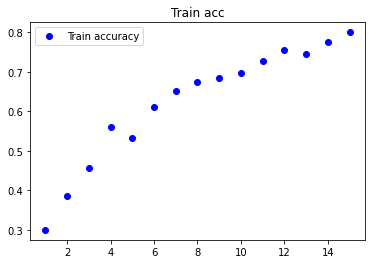

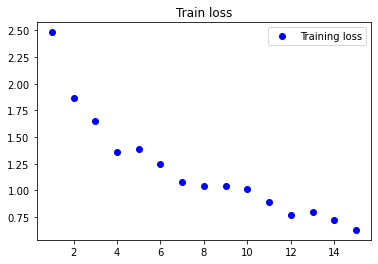

In [13]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 80,
    epochs = 15
)

train_model(history)

###### Test the Model

In [14]:
test_acc_simple_cnn = test_model(model)

c:\Users\Rafael\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
c:\Users\Rafael\AppData\Local\Programs\Python\Python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Test Accuracy:
 0.6049743890762329


###### Confusion Matrix

In [15]:
generate_confusion_matrix(model)

<tf.Tensor: shape=(11, 11), dtype=int32, numpy=
array([[108,   0,   2,   5,   0,   2,   0,   2,   1,   1,   0],
       [  0, 148,   1,   2,   1,   9,  10,  14,  10,  36,   5],
       [  1,   0,  28,   4,   6,   1,   1,   0,   2,   0,   3],
       [  2,   0,  11,  51,   9,   1,  11,   0,   4,   0,   4],
       [  5,   2,   7,   8,  70,  14,   9,   5,   4,   0,   2],
       [  0,   0,   0,   0,   0,  13,   0,   0,   0,   0,   0],
       [ 10,   0,  16,  15,  11,   0,  40,   2,   4,   1,   7],
       [  0,   1,   0,   0,   0,   2,   0,   9,   0,   1,   0],
       [  8,   7,  14,  23,   4,  28,   9,   9, 183,   4,  20],
       [  2,   6,   0,   0,   1,   0,   0,   4,   0,  95,   0],
       [  3,   5,  16,  19,  16,   5,  25,   1,  24,   0,  82]])>

##### Data Augmentation

###### Train Generator

In [16]:
train_aug_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True
)
train_aug_generator = train_aug_datagen.flow_from_directory(
    train_path,
    target_size = (WIDTH, HEIGHT),
    batch_size = 8,
    class_mode ='categorical'
)

Found 4809 images belonging to 11 classes.


###### Display augmented images for training

11 classes
{'dew': 0, 'fogsmog': 1, 'frost': 2, 'glaze': 3, 'hail': 4, 'lightning': 5, 'rain': 6, 'rainbow': 7, 'rime': 8, 'sandstorm': 9, 'snow': 10}


<Figure size 432x288 with 0 Axes>

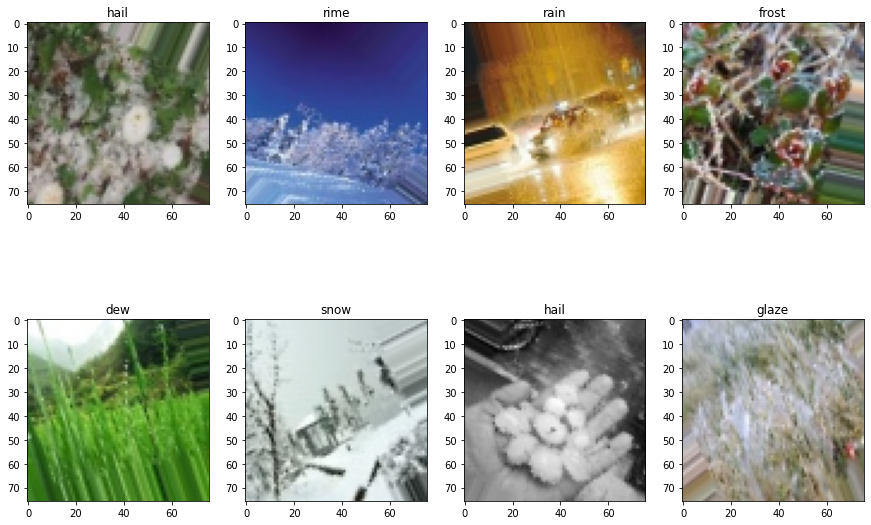

In [17]:
class_indices = train_aug_generator.class_indices
print(str(len(class_indices)) + ' classes')
print(class_indices)

images, labels = train_aug_generator[0]

plt.figure()
f, axarr = plt.subplots(2, int(images.shape[0] / 2), figsize=(15, 10)) 

img_index = 0 
for row in range(0, 2):
	for col in range(0, int(images.shape[0] / 2)):
		axarr[row][col].imshow(images[img_index])
		img_class_index = np.where(labels[img_index] == 1)[0]
		img_class = get_img_class(class_indices, img_class_index)
		axarr[row][col].set_title(img_class)
		img_index += 1

###### Create model

In [18]:
model_aug = models.Sequential()

model_aug.add(layers.Conv2D(10, (3, 3), activation="relu", input_shape = (WIDTH,HEIGHT,3)))
model_aug.add(layers.Flatten())
model_aug.add(layers.Dense(64, activation='relu'))
model_aug.add(layers.Dense(11, activation='softmax')) 

model_aug.summary()

model_aug.compile(
    loss='categorical_crossentropy',
	optimizer='Adam',
	metrics=['acc']
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 74, 74, 10)        280       
_________________________________________________________________
flatten_1 (Flatten)          (None, 54760)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                3504704   
_________________________________________________________________
dense_3 (Dense)              (None, 11)                715       
Total params: 3,505,699
Trainable params: 3,505,699
Non-trainable params: 0
_________________________________________________________________


###### Train the model

Epoch 1/15
80/80 [==============================] - 4s 42ms/step - loss: 7.1387 - acc: 0.1782
Epoch 2/15
80/80 [==============================] - 3s 41ms/step - loss: 1.9487 - acc: 0.3441
Epoch 3/15
80/80 [==============================] - 4s 45ms/step - loss: 1.7865 - acc: 0.4303
Epoch 4/15
80/80 [==============================] - 4s 48ms/step - loss: 1.5421 - acc: 0.4747
Epoch 5/15
80/80 [==============================] - 4s 46ms/step - loss: 1.5695 - acc: 0.4574
Epoch 6/15
80/80 [==============================] - 4s 50ms/step - loss: 1.5314 - acc: 0.4761
Epoch 7/15
80/80 [==============================] - 4s 45ms/step - loss: 1.5448 - acc: 0.5134
Epoch 8/15
80/80 [==============================] - 3s 40ms/step - loss: 1.4308 - acc: 0.5352
Epoch 9/15
80/80 [==============================] - 3s 40ms/step - loss: 1.4569 - acc: 0.5115
Epoch 10/15
80/80 [==============================] - 3s 42ms/step - loss: 1.4908 - acc: 0.5063
Epoch 11/15
80/80 [==============================] - 3s 41m

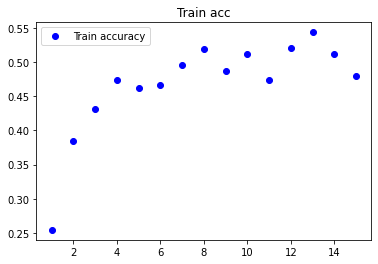

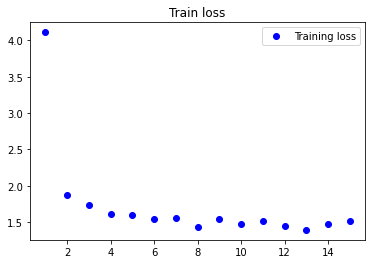

In [19]:
history_aug = model_aug.fit_generator(
    train_aug_generator,
    steps_per_epoch = 80,
    epochs = 15
)

train_model(history_aug)

###### Test the model

In [20]:
test_acc_aug = test_model(model_aug)


Test Accuracy:
 0.4250182807445526


###### Confusion Matrix

In [21]:
generate_confusion_matrix(model_aug)

<tf.Tensor: shape=(11, 11), dtype=int32, numpy=
array([[ 76,   0,   0,   2,   0,   2,   0,   0,   0,   0,   0],
       [  1, 112,   0,   0,   0,   7,   4,  11,   1,  35,   1],
       [ 16,   0,  15,  11,   7,   1,   2,   0,   1,   0,   1],
       [  5,   0,  30,  27,  11,   2,   6,   0,   7,   0,   1],
       [  3,   1,   1,   0,  22,   4,   2,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   3,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   1,   0,   3,   0,   0,   0],
       [ 12,  51,  16,  36,  31,  53,  27,  28, 193,  32,  60],
       [  4,   5,   0,   0,   1,   0,   0,   2,   0,  70,   0],
       [ 21,   0,  33,  51,  46,   2,  64,   2,  30,   1,  60]])>

##### Data Validation

###### Validation generator

In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size = (WIDTH,HEIGHT),
    batch_size = 8,
    class_mode= 'categorical'
)

Found 684 images belonging to 11 classes.


###### Create model

In [23]:
model_val = models.Sequential()

model_val.add(layers.Conv2D(10, (3, 3), activation="relu", input_shape = (WIDTH,HEIGHT,3)))
model_val.add(layers.Flatten())
model_val.add(layers.Dense(64, activation='relu'))
model_val.add(layers.Dense(11, activation='softmax')) 

model_val.summary()

model_val.compile(
    loss='categorical_crossentropy',
	optimizer='Adam',
	metrics=['acc']
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 74, 74, 10)        280       
_________________________________________________________________
flatten_2 (Flatten)          (None, 54760)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                3504704   
_________________________________________________________________
dense_5 (Dense)              (None, 11)                715       
Total params: 3,505,699
Trainable params: 3,505,699
Non-trainable params: 0
_________________________________________________________________


###### Train the model

Epoch 1/15
80/80 [==============================] - 6s 64ms/step - loss: 2.5795 - acc: 0.1873 - val_loss: 2.0848 - val_acc: 0.2656
Epoch 2/15
80/80 [==============================] - 4s 55ms/step - loss: 2.0982 - acc: 0.2762 - val_loss: 2.2118 - val_acc: 0.2812
Epoch 3/15
80/80 [==============================] - 4s 56ms/step - loss: 1.7899 - acc: 0.4466 - val_loss: 1.7927 - val_acc: 0.4375
Epoch 4/15
80/80 [==============================] - 4s 51ms/step - loss: 1.8065 - acc: 0.4058 - val_loss: 1.8826 - val_acc: 0.3750
Epoch 5/15
80/80 [==============================] - 4s 48ms/step - loss: 1.7225 - acc: 0.4520 - val_loss: 1.6788 - val_acc: 0.5000
Epoch 6/15
80/80 [==============================] - 4s 50ms/step - loss: 1.4877 - acc: 0.4930 - val_loss: 1.6127 - val_acc: 0.4844
Epoch 7/15
80/80 [==============================] - 4s 48ms/step - loss: 1.5654 - acc: 0.4781 - val_loss: 1.3731 - val_acc: 0.5625
Epoch 8/15
80/80 [==============================] - 4s 47ms/step - loss: 1.4652 - a

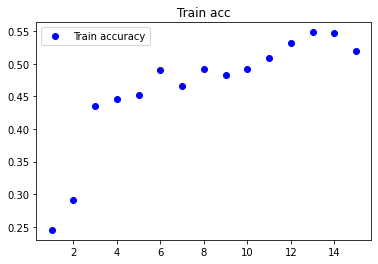

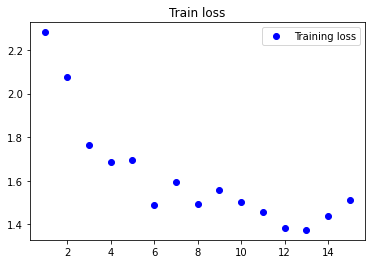

In [24]:
# We use the already created model_aug
history_val = model_val.fit_generator(
    train_aug_generator,
    steps_per_epoch=80,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=8
)

train_model(history_val)

###### Test the model

In [25]:
test_acc_val = test_model(model_val)


Test Accuracy:
 0.49378201365470886


##### Transfer Learning

###### VGG Generator

In [26]:
vgg_datagen = ImageDataGenerator(1./255)
train_vgg_generator = vgg_datagen.flow_from_directory(
    train_path,
    target_size = (WIDTH,HEIGHT),
    batch_size = 8,
    class_mode= 'categorical'
)

Found 4809 images belonging to 11 classes.


###### Hacer la base del modelo

In [27]:
vgg_conv_base= VGG16(
    weights='imagenet',
    include_top = False,
	input_shape = (WIDTH,HEIGHT,3)
)

In [28]:
model_vgg = models.Sequential()

model_vgg.add(vgg_conv_base)
model_vgg.add(layers.Flatten())
model_vgg.add(layers.Dense(64,activation='relu'))
model_vgg.add(layers.Dense(11, activation='softmax'))

vgg_conv_base.trainable = False

model_vgg.summary()

model_vgg.compile(
    loss='categorical_crossentropy',
	optimizer='Adam',
	metrics=['acc']
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                131136    
_________________________________________________________________
dense_7 (Dense)              (None, 11)                715       
Total params: 14,846,539
Trainable params: 131,851
Non-trainable params: 14,714,688
_________________________________________________________________


###### Train the model

Epoch 1/15
80/80 [==============================] - 29s 357ms/step - loss: 9.1564 - acc: 0.3099 - val_loss: 2.3662 - val_acc: 0.0938
Epoch 2/15
80/80 [==============================] - 26s 326ms/step - loss: 2.3317 - acc: 0.5627 - val_loss: 2.3459 - val_acc: 0.1406
Epoch 3/15
80/80 [==============================] - 28s 350ms/step - loss: 1.3416 - acc: 0.6010 - val_loss: 2.3535 - val_acc: 0.3125
Epoch 4/15
80/80 [==============================] - 28s 353ms/step - loss: 1.2045 - acc: 0.6345 - val_loss: 2.3591 - val_acc: 0.2031
Epoch 5/15
80/80 [==============================] - 26s 330ms/step - loss: 1.1825 - acc: 0.7003 - val_loss: 2.3402 - val_acc: 0.1875
Epoch 6/15
80/80 [==============================] - 28s 349ms/step - loss: 1.1105 - acc: 0.6576 - val_loss: 2.3109 - val_acc: 0.1875
Epoch 7/15
80/80 [==============================] - 27s 343ms/step - loss: 0.9449 - acc: 0.7174 - val_loss: 2.3352 - val_acc: 0.2031
Epoch 8/15
80/80 [==============================] - 28s 347ms/step - 

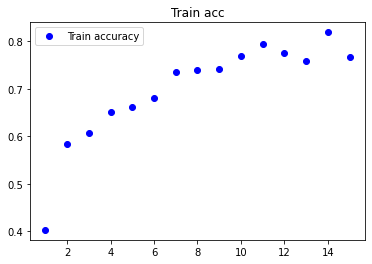

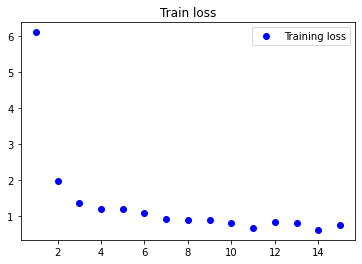

In [29]:
history_vgg = model_vgg.fit_generator(
    train_vgg_generator,
    steps_per_epoch = 80,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = 8
)

train_model(history_vgg)

###### Test the model

In [30]:
test_acc_vgg = test_model(model_vgg)


Test Accuracy:
 0.6642282605171204


###### Confusion Matrix

In [31]:
generate_confusion_matrix(model_vgg)

<tf.Tensor: shape=(11, 11), dtype=int32, numpy=
array([[ 90,   0,   4,   6,   3,   1,   1,   4,   1,   2,   0],
       [  4, 135,   2,   2,   0,   4,   6,   1,   7,  24,   6],
       [ 12,   0,  35,   8,   6,   0,   0,   0,   2,   1,   3],
       [ 11,   1,  25,  64,   8,   0,   1,   0,  22,   0,  10],
       [  8,   0,   6,   5,  88,   3,   5,   3,   0,   0,   3],
       [  3,   5,   4,   1,   1,  56,   2,   3,   1,   3,   1],
       [  0,   1,   1,   1,   0,   0,  61,   0,   0,   2,   6],
       [  3,   4,   0,   0,   1,   0,   2,  33,   2,   2,   1],
       [  1,   8,  15,  30,   4,   6,   5,   2, 183,   7,  18],
       [  2,   8,   1,   1,   1,   4,   3,   0,   3,  90,   2],
       [  5,   7,   2,   9,   6,   1,  19,   0,  11,   7,  73]])>

#### Graph Results

##### Grouped Accuracy Bars for Training and Testing

In [ ]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

import matplotlib.pyplot as plt
import numpy as np


# Should use saved test_acc variables

models = ("Simple CNN", "Augmented CNN", "VGG16")
accuracies = {
    'Training': (0.855, 0.4706, 0.7945),
    'Test': (0.6049, 0.4250, 0.6642),
}

label_pos = np.arange(len(models))  # the label locations
width = 0.33
multiplier = 0.5

fig, ax = plt.subplots()

for attribute, measurement in accuracies.items():
    offset = width * multiplier
    rects = ax.bar(label_pos + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1


ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison for Different Architectures')
ax.set_xticks(label_pos + width, models)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 1.2)

plt.show()

# See Graph in: http://tpcg.io/_SY70M4

![Accuracy Comparison for Different Architectures](accuracies_for_architectures.png)